# Loss and Portfolio Management

historical returns, realized volatility, VaR, Sharpe, CAPM

In [1]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from arch import arch_model
from datetime import timedelta
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Part 1: Historical returns

In [2]:
stocks =['SUN.AX','NAB.AX','DMP.AX','IEL.AX','QAN.AX','ASX.AX']
start_date = dt.datetime(2022, 3, 30)
end_date = dt.datetime(2023, 3, 30)
getData = yf.download(stocks, start=start_date, end=end_date) 
Data = getData['Close']
data = Data.pct_change()
returns = data.dropna()
returns['Portfolio'] = returns[stocks[:5]].sum(axis=1)

# Rearrange table columns
returns = returns[[c for c in returns if c not in ['ASX.AX','Portfolio']]
        + ['ASX.AX','Portfolio']]

returns = returns*100
returns.head()

[*********************100%***********************]  6 of 6 completed


<ipython-input-2-9a6bb8052c08>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['Portfolio'] = returns[stocks[:5]].sum(axis=1)


,DMP.AX,IEL.AX,NAB.AX,QAN.AX,SUN.AX,ASX.AX,Portfolio
Date,,,,,,,
2022-03-31,0.182456,-0.031656,-0.061787,-0.950574,-0.802856,0.306560,-1.664417
2022-04-01,-3.972678,-4.844841,-0.061813,0.575811,-0.179852,-0.794623,-8.483374
2022-04-04,-1.837367,-1.597336,-0.804213,-1.526716,-0.180184,1.528032,-5.945817
2022-04-05,-0.217365,0.845451,0.343002,0.193803,-0.180501,0.194203,0.984390
2022-04-06,0.810851,-1.509051,1.180861,-1.353968,-2.169988,0.169593,-3.041296


In [3]:
# summarize the data
print("Descriptive Statistics")
returns.describe()

Descriptive Statistics


,DMP.AX,IEL.AX,NAB.AX,QAN.AX,SUN.AX,ASX.AX,Portfolio
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,-0.182192,-0.039333,-0.063228,0.103144,0.037668,-0.083115,-0.143941
std,3.037715,2.244552,1.297596,1.979140,1.585335,1.299414,6.773290
min,-23.808859,-9.152681,-4.347824,-6.800612,-6.353131,-4.821156,-24.468778
25%,-1.405135,-1.496715,-0.761195,-1.062152,-0.798254,-0.786979,-4.324154
50%,-0.040770,-0.071970,0.033345,0.000000,0.084036,-0.028343,-0.286639
75%,1.202291,1.121323,0.834296,1.193229,0.835283,0.600743,4.046813
max,7.600903,7.543103,3.967982,8.704058,6.126120,3.754785,21.767294


### Observation 1
* All stocks have an average daily returns of approximately between -0.197% to 0.123%.
* The compound standard deviation of the portfolio (6.742%) is almost 5.1 times higher than that of ASX (1.32%).
* With a minimum loss of -23.809%, DMP.AX stock has the lowest daily return among the five, and almost 5 times higher loss than ASX (-4.821%).
* With a maximum gain of 8.704%, QAN.AX stock has the highest daily return and 2.32 times greater than ASX (3.755%).
* **DMP.AX**: Range of Q1 to Q3 is between -1.46% to 1.241%. Since mean is less than median, we can say that DMP.AX is left (negatively) skewed.
* **IEL.AX**: Range of Q1 to Q3 is between -1.479% to 1.239%. Since mean is greater than median, we can say that IEL.AX is right (positively) skewed.
* **NAB.AX**: Range of Q1 to Q3 is between -0.661% to 0.837%. Since mean is less than median, we can say that NAB.AX is left (negatively) skewed.
* **QAN.AX**: Range of Q1 to Q3 is between -1.062% to 1.193%. Since mean is greater than median, we can say that QAN.AX is right (positively) skewed.
* **SUN.AX**: Range of Q1 to Q3 is between -0.798% to 0.835%. Since mean is less than median, we can say that QAN.AX is left (negatively) skewed.
* **ASX.AX**: Range of Q1 to Q3 is between -0.787% to 0.601%. Since mean is less than median, we can say that market is left (negatively) skewed.

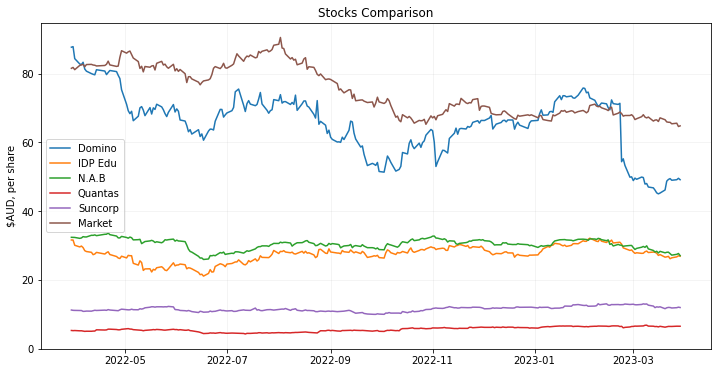

In [20]:
plt.figure(figsize=(12,6))
plt.plot(Data['DMP.AX'], label='Domino')
plt.plot(Data['IEL.AX'], label='IDP Edu')
plt.plot(Data['NAB.AX'], label='N.A.B')
plt.plot(Data['QAN.AX'], label='Quantas')
plt.plot(Data['SUN.AX'], label='Suncorp')
plt.plot(Data['ASX.AX'], label='Market')
plt.title('Stocks Comparison', fontsize=12)
plt.ylabel('$AUD, per share')
plt.grid(True, color='grey', alpha=0.1)
plt.legend()
plt.show()

# Part 2: Value at Risk

In [21]:
work_day=252
split_date = returns.iloc[-work_day:].index
VaR_p = returns['Portfolio'].quantile(0.01)
VaR_m = returns['ASX.AX'].quantile(0.01)
print('1-Day Maximum Loss, %')
print('Portfolio: ',round(VaR_p,3))
print('ASX: ',round(VaR_m,3))

1-Day Maximum Loss, %
Portfolio:  -16.17
ASX:  -3.687


### Observation 2
For every 1 day trading period, there is 95% chance that the portfolio will incur a trading loss of up to 16.17% while the market suffer a loss up to 3.687%

# Part 3: Volatility

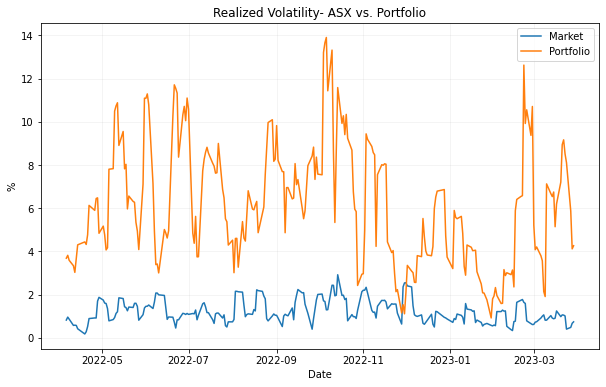

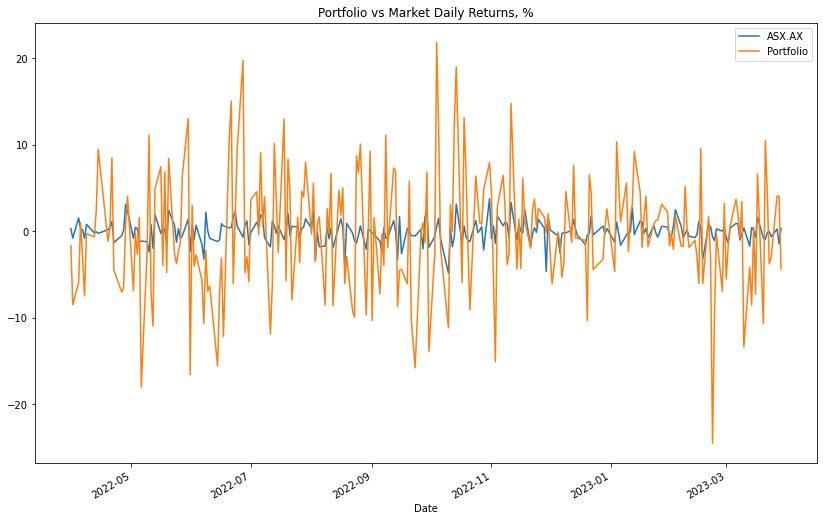

In [22]:
realized_vol = returns[['ASX.AX','Portfolio']].rolling(5).std()
market_realized_vol = returns[['ASX.AX']].rolling(5).std()
portfolio_realized_vol = returns['Portfolio'].rolling(5).std()
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[['ASX.AX']], label='Market')
plt.plot(realized_vol[['Portfolio']], label='Portfolio')
plt.title('Realized Volatility- ASX vs. Portfolio')
plt.ylabel('%')
plt.xlabel('Date')
plt.grid(True, color='grey', alpha=0.1)
plt.legend()
plt.show()

# visualize the data
returns[[stocks[5],'Portfolio']].plot(title='Portfolio vs Market Daily Returns, %', figsize=(14,9));
# returns['Portfolio'].plot(title='', figsize=(8,8))

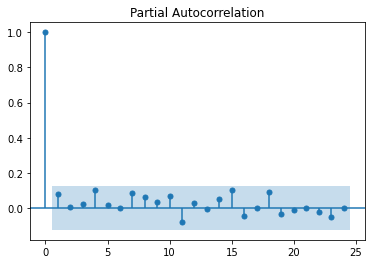

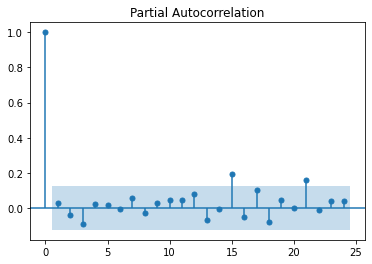

In [7]:
plot_pacf(returns['Portfolio']**2)
plt.show()

plot_pacf(returns['ASX.AX']**2)
plt.show()

In [8]:
garch = arch_model(returns['Portfolio'], mean='zero', vol='GARCH',
                   p=1, o=0, q=1)\
            .fit()
print(garch.summary())
forecasts = garch.forecast(horizon=10)
future_dates = [returns['Portfolio'].index[-1] + timedelta(days=i) for i in range(1,11)]
pred_chart = pd.Series(np.sqrt(forecasts.variance.values[-1,:]), index = future_dates)
# rmse_garch = np.sqrt(mse(realized_vol[-work_day:] / 100,
#                          np.sqrt(forecast_garch\
#                          .variance.iloc[-len(split_date):]
#                          / 100)))
# print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1031.2811562588522
Iteration:      2,   Func. Count:     11,   Neg. LLF: 838.2353557288736
Iteration:      3,   Func. Count:     16,   Neg. LLF: 839.7821562307016
Iteration:      4,   Func. Count:     21,   Neg. LLF: 831.8825525990314
Iteration:      5,   Func. Count:     26,   Neg. LLF: 831.7289052776773
Iteration:      6,   Func. Count:     30,   Neg. LLF: 831.7278058270737
Iteration:      7,   Func. Count:     34,   Neg. LLF: 831.7277958287518
Iteration:      8,   Func. Count:     38,   Neg. LLF: 831.727795466014
Optimization terminated successfully    (Exit mode 0)
            Current function value: 831.727795466014
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Portfolio   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:     

C:\Users\Admin\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


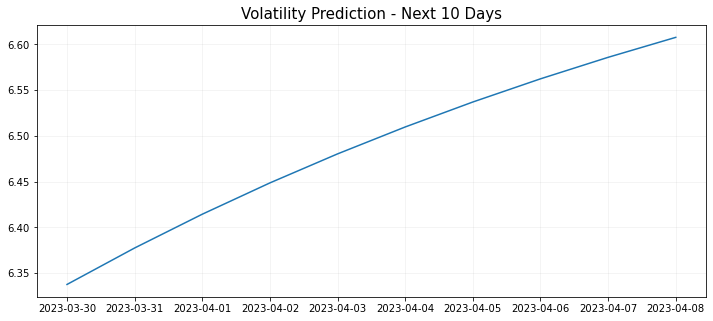

In [27]:
plt.figure(figsize=(12,5))
plt.plot(pred_chart)
plt.title("Volatility Prediction - Next 10 Days", fontsize=15)
plt.grid(True, color='grey', alpha=0.1)

# Part 4: Expected Return

In [30]:
cov = returns.cov()
var = returns['ASX.AX'].var()
beta = cov.loc['ASX.AX','Portfolio']/var
 
risk_free_rate = 3.781
market_return = returns[['ASX.AX']].mean()
expected_return = risk_free_rate + beta*(market_return - risk_free_rate)
print('Market return:',market_return)
print('Expected return:',expected_return)

Market return: ASX.AX   -0.083115
dtype: float64
Expected return: ASX.AX   -4.128601
dtype: float64


If you invest in ASX 200, you might incur less loss in seems-to-be bear market, compared to the portfolio

# Conclusion